In [8]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
from legged_gym import LEGGED_GYM_ROOT_DIR
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [122]:
def plot_error_lineplots(list_infos, xlabel="Freq", ylabel="Power", names=["Metal"]):
  combined_df = []
  for j, list_info in tqdm(enumerate(list_infos)):
    sizes = [len(sample) for sample in list_info]
    cutting_th = min(sizes)

    new_df = pd.DataFrame()
    subdf_n_average = []
    for yf in list_info:
      xf = np.arange(cutting_th)*0.005*4
      xf, yf = xf[:cutting_th], yf[:cutting_th]
      data = {xlabel: xf,
              ylabel: yf}
      sub_df = pd.DataFrame(data)
      subdf_n_average.append(sub_df)
    new_df = pd.concat(subdf_n_average)
    new_df["Texture"] = names[j]
    combined_df.append(new_df)
  combined_df = pd.concat(combined_df)
  #Plot
  sns.set(style="whitegrid")
  sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
  sns.lineplot(x=xlabel, y=ylabel, data=combined_df, errorbar="sd", hue="Texture")

def smooth(y, smooth_factor=0.6):
    smoothed_y = np.zeros_like(y)
    smoothed_y[0] = y[0]
    for i in range(1, len(y)):
        smoothed_y[i] = smooth_factor * y[i] + (1 - smooth_factor) * smoothed_y[i - 1]
    return smoothed_y

def smoothing_plot(x, y, smooth_factor=0.6, window_size = 10, label=None):
    smoothed_y = smooth(y, smooth_factor)
    
    # Calculate standard deviation (SD)
    window_size = window_size
    y_diff = -np.array(smoothed_y)+np.array(y)
    y_std = [np.std(y_diff[max(0, i-window_size-1):i]) for i in range(len(y_diff))]
    
    sns.set(style="whitegrid")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    
    # Plot smoothed data
    line_plot, = plt.plot(x, smoothed_y, label=label)
    plot_color = line_plot.get_color()
    # Add SD shading
    plt.fill_between(x, smoothed_y - y_std, smoothed_y + y_std, color=plot_color, alpha=0.2)

2it [00:00, 25.14it/s]


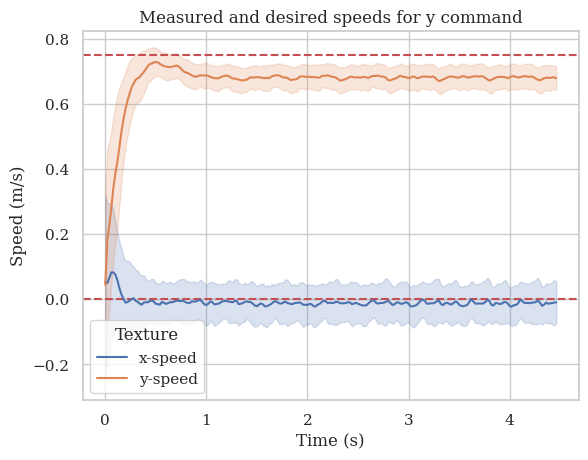

In [95]:
#Measured speed
fname = "plane-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname+'.json'), 'r') as file:
    data = json.load(file)[0]  # Load and parse the JSON file

speed_x = data["vel_x"]
speed_y = data["vel_y"]

plt.figure()
plt.axhline(y=float(fname.split("-")[-3]), color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Measured and desired speeds for y command")
plot_error_lineplots([speed_x, speed_y], xlabel="Time (s)", ylabel="Speed (m/s)", names=["x-speed", "y-speed"])
plt.show()

/home/zetans/mambaforge/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/zetans/mambaforge/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/zetans/mambaforge/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


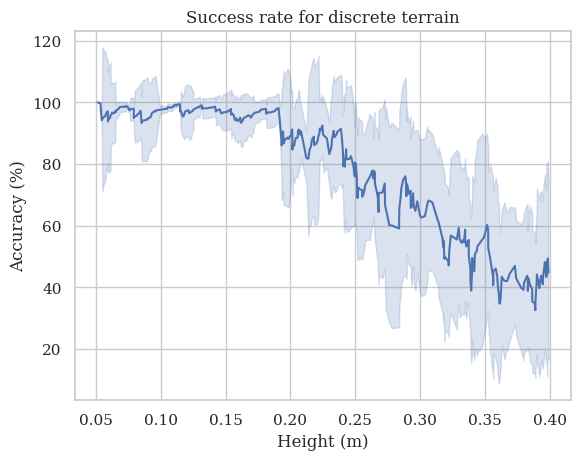

In [124]:
#Discrete
def myFunc(e):
  return e[metric]

fname = "discrete-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file

data.sort(key=myFunc)
accuracy = [item["successful"]*100/item["total"] for item in data]
slope = [item[metric] for item in data]

smoothing_plot(slope, accuracy, smooth_factor=0.1)
plt.xlabel('Slope' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()

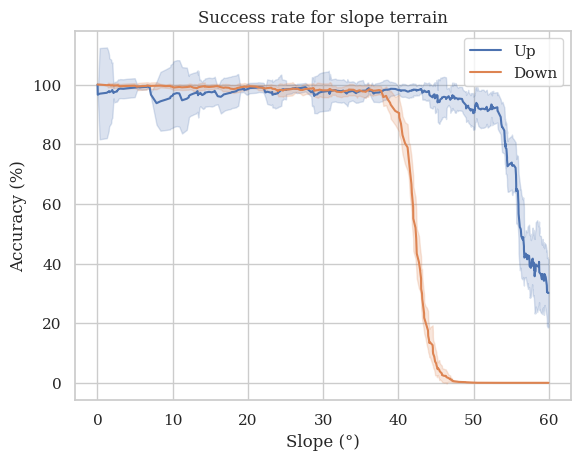

In [133]:
#Slope or stairs
def myFunc(e):
  return e[metric]

def get_x_y(data):
    data.sort(key=myFunc)
    y = [item["successful"]*100/item["total"] for item in data]
    if metric=="slope":
        x = [np.rad2deg(np.arctan(item[metric])) for item in data]
    else:    
        x = [item[metric] for item in data]
    return x,y

fname = "slope-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname.replace("None", "False")+'.json'), 'r') as file:
    data_up = json.load(file)  # Load and parse the JSON file
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname.replace("None", "True")+'.json'), 'r') as file:
    data_down = json.load(file)  # Load and parse the JSON file

x_down, y_down = get_x_y(data_down)
x_up, y_up = get_x_y(data_up)

smoothing_plot(x_down, y_down, smooth_factor=0.1, label="Up")
smoothing_plot(x_up, y_up, smooth_factor=0.1, label="Down")
plt.xlabel('Slope (°)' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()